# Elements for Stokes

Hello there!

Import some stuff

In [1]:
from dolfinx import fem, mesh
from dolfinx import cpp as _cpp

import ufl
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
import basix
import basix.ufl_wrapper

import matplotlib.pylab as plt

## Defining a Stokes solver

TODO: some text here, probably split this code into multiple cells.

In [2]:
def velocity(x, y):
    a = 2*np.pi*ufl.sin(np.pi*x)*ufl.sin(np.pi*y)
    b = ufl.sin(np.pi*x)*ufl.cos(np.pi*y)
    c = ufl.cos(np.pi*x)*ufl.sin(np.pi*y)

    return (a*b, -a*c)


def rhs(x, y):
    f1 = ufl.sin(2*np.pi*y)*(ufl.cos(2*np.pi*x) - 2*np.pi**2*ufl.cos(2*np.pi*x) + np.pi**2)
    f2 = ufl.sin(2*np.pi*x)*(ufl.cos(2*np.pi*y) + 2*np.pi**2*ufl.cos(2*np.pi*y) - np.pi**2)

    return(2*np.pi*f1, 2*np.pi*f2)


def solve_stokes(element, domain):
    V = fem.FunctionSpace(domain, element.sub_elements()[0])
    Q = fem.FunctionSpace(domain, element.sub_elements()[1])
    x = ufl.SpatialCoordinate(domain)
    u_soln = ufl.as_vector(velocity(x[0], x[1]))

    # Velocity boundary condition
    g = fem.Function(V)
    g.x.set(0.0)
    bdry_facets = mesh.locate_entities_boundary(
        domain, domain.topology.dim - 1, lambda x: np.ones(x.shape[1], dtype=np.bool8))
    dofs = fem.locate_dofs_topological(V, domain.topology.dim-1, bdry_facets)
    bcv = fem.dirichletbc(g, dofs)

    bcs = [bcv]

    # Define variational problem
    u, p = ufl.TrialFunction(V), ufl.TrialFunction(Q)
    v, q = ufl.TestFunction(V), ufl.TestFunction(Q)
    f = fem.Function(V)
    f_expr = fem.Expression(ufl.as_vector(rhs(x[0], x[1])), V.element.interpolation_points())
    f.interpolate(f_expr)
    a = fem.form([[ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx, ufl.inner(p, ufl.div(v)) * ufl.dx],
              [ufl.inner(ufl.div(u), q) * ufl.dx, None]])
    L = fem.form([ufl.inner(f, v) * ufl.dx, ufl.inner(fem.Constant(domain, PETSc.ScalarType(0)), q) * ufl.dx])

    # We will use a block-diagonal preconditioner to solve this problem:

    a_p11 = fem.form(ufl.inner(p, q) * ufl.dx)
    a_p = [[a[0][0], None],
           [None, a_p11]]

    # Assemble LHS matrix and RHS vector
    A = fem.petsc.assemble_matrix_nest(a, bcs=bcs)
    A.assemble()

    # We create a nested matrix `P` to use as the preconditioner. The
    # top-left block of `P` is shared with the top-left block of `A`. The
    # bottom-right diagonal entry is assembled from the form `a_p11`:

    P11 = fem.petsc.assemble_matrix(a_p11, [])
    P = PETSc.Mat().createNest([[A.getNestSubMatrix(0, 0), None], [None, P11]])
    P.assemble()
    b = fem.petsc.assemble_vector_nest(L)

    fem.petsc.apply_lifting_nest(b, a, bcs=bcs)
    # Sum contributions from ghost entries on the owner
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    bcs0 = fem.bcs_by_block(fem.extract_function_spaces(L), bcs)
    fem.petsc.set_bc_nest(b, bcs0)

    # Create nullspace vector
    null_vec = fem.petsc.create_vector_nest(L)

    # Set velocity part to zero and the pressure part to a non-zero constant
    null_vecs = null_vec.getNestSubVecs()
    null_vecs[0].set(0.0), null_vecs[1].set(1.0)

    # Normalize the vector, create a nullspace object, and attach it to the
    # matrix
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)
    # Now we create a Krylov Subspace Solver `ksp`. We configure it to use
    # the MINRES method, and a block-diagonal preconditioner using PETSc's
    # additive fieldsplit type preconditioner:

    # +
    ksp = PETSc.KSP().create(domain.comm)
    ksp.setOperators(A, P)
    ksp.setType("minres")
    ksp.setTolerances(rtol=1e-9)
    ksp.getPC().setType("fieldsplit")
    ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)

    # Define the matrix blocks in the preconditioner with the velocity and
    # pressure matrix index sets
    nested_IS = P.getNestISs()
    ksp.getPC().setFieldSplitIS(
        ("u", nested_IS[0][0]),
        ("p", nested_IS[0][1]))

    # Set the preconditioners for each block
    ksp_u, ksp_p = ksp.getPC().getFieldSplitSubKSP()
    ksp_u.setType("preonly")
    ksp_u.getPC().setType("gamg")
    ksp_p.setType("preonly")
    ksp_p.getPC().setType("jacobi")

    # Monitor the convergence of the KSP
    ksp.setFromOptions()
    # Compute the solution
    u = fem.Function(V)
    p = fem.Function(Q)
    x = PETSc.Vec().createNest([_cpp.la.petsc.create_vector_wrap(u.x), _cpp.la.petsc.create_vector_wrap(p.x)])
    ksp.solve(b, x)
    u.x.scatter_forward()
    p.x.scatter_forward()

    error = u - u_soln
    velocity_error = domain.comm.allreduce(
        fem.assemble.assemble_scalar(
            fem.form(ufl.inner(error, error) * ufl.dx + ufl.inner(ufl.grad(error), ufl.grad(error)) * ufl.dx)) ** 0.5,
            # fem.form(ufl.inner(error, error) * ufl.dx)) ** 0.5,
        op=MPI.SUM)
    
    # TODO
    from random import random
    pressure_error = random()
    
    return velocity_error, pressure_error

TODO: some text here

In [3]:
def compute_errors(element, nmeshes=5):
    N0 = 10
    hs = []
    velocity_errors = []
    pressure_errors = []
    for k in range(nmeshes):
        N = N0 * 2 ** k
        hs.append(1./N)
        domain = mesh.create_rectangle(
            MPI.COMM_WORLD, [np.array([0, 0]), np.array([1, 1])],
            [N, N], mesh.CellType.triangle, mesh.GhostMode.none)
        e1, e2 = solve_stokes(element, domain)
        velocity_errors.append(e1)
        pressure_errors.append(e2)
    return hs, velocity_errors, pressure_errors

## The elements

We now use the Stokes solver we have defined to experiment with a range of element pairs that can be used. First, we define a function that takes an element as input and plots a graph showing the error as $h$ is decreased.

In [4]:
%matplotlib inline

def error_plot(element, convergence=None, nmeshes=5):
    hs, v_errors, p_errors = compute_errors(element, nmeshes)

    legend = []
    if convergence is not None:
        y_value = 1.2 * v_errors[0]
        plt.plot([hs[0], hs[-1]], [y_value, y_value * (hs[-1] / hs[0])**convergence], "k--")
        legend.append(f"order {convergence}")
    plt.plot(hs, v_errors, "bo-")
    # plt.plot(hs, p_errors, "ro-")
    legend += ["velocity", "pressure"]
    plt.legend(legend)
    plt.xscale("log")
    plt.yscale("log")
    plt.axis("equal")
    plt.ylabel("Error in energy norm")
    plt.xlabel("$h$")
    plt.xlim(plt.xlim()[::-1])

## Piecewise constant pressure spaces

For our first element, we pair piecewise linear elements with piecewise constants. Using these elements, we do not converge to the solution.

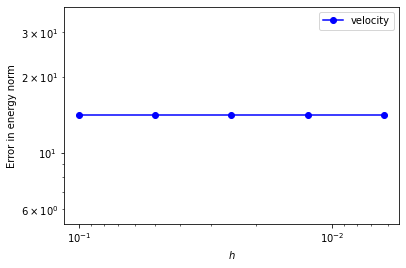

In [5]:
element = ufl.MixedElement(
    ufl.VectorElement("Lagrange", "triangle", 1),
    ufl.FiniteElement("DG", "triangle", 0))

error_plot(element)

One way to obtain convergence with a piecewise constant pressure space is to use a piecewise quadratic space for the velocity (Fortin, 1972).

  warnings.warn(



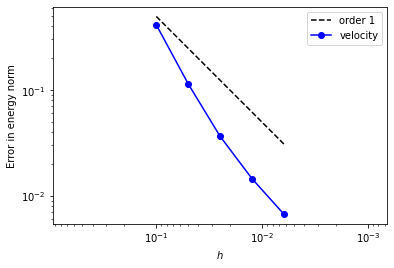

In [6]:
element = ufl.MixedElement(
    ufl.VectorElement("Lagrange", "triangle", 2),
    ufl.FiniteElement("DG", "triangle", 0))

error_plot(element, 1)

Alternatively, the same order convergence can be achieved using fewer degrees of freedom if a Crouzeix-Raviart element is used for the velocity space (Crouziex, Raviart, 1973).

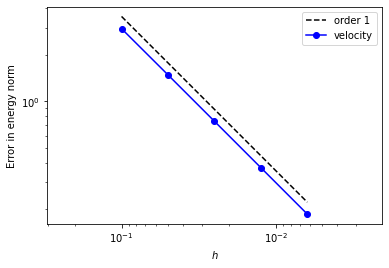

In [7]:
element = ufl.MixedElement(
    ufl.VectorElement("CR", "triangle", 1),
    ufl.FiniteElement("DG", "triangle", 0))

error_plot(element, 1)

## Piecewise linear pressure space

When using a piecewise linear pressure space, we could again try using a velocity space one degree higher, but we would again observe that there is no convergence. In order to achieve convergence, we can augment the quadratic space with a cubic bubble function on the triangle (Crouziex, Falk, 1988).

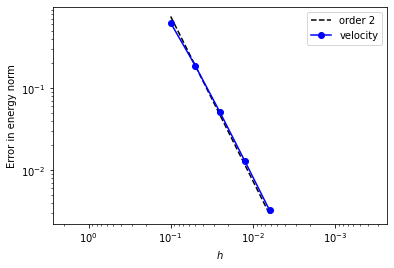

In [8]:
element = ufl.MixedElement(
    ufl.VectorElement(ufl.EnrichedElement(
        ufl.FiniteElement("Lagrange", "triangle", 2),
        ufl.FiniteElement("Bubble", "triangle", 3))),
    ufl.FiniteElement("DG", "triangle", 1))

error_plot(element, 2)

## Piecewise quadratic pressure space

When using a piecewise quadratic space, we want to use a cubic velocity space. This cubic space must be augmented with quartic bubble functions. We have to define these bubble functions using a custom element, as the basis functions of a degree 3 Lagrange space and a degree 4 bubble space are not linearly independent: the custom element omits one of the bubbles (Crouzeix, Falk, 1988).

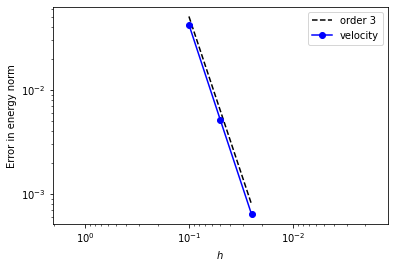

In [9]:
wcoeffs = np.zeros((9, 10))
pts, wts = basix.make_quadrature(basix.CellType.triangle, 6)
poly = basix.tabulate_polynomials(basix.PolynomialType.legendre, basix.CellType.triangle, 3, pts)
x = pts[:, 0]
y = pts[:, 1]
f = x * (1 - x) * y * (1 - y)
for j, f in enumerate([
    1, x, y, x**2*y, x*y**2, (1-x-y)**2*y, (1-x-y)*y**2, x**2*(1-x-y), x*(1-x-y)**2
]):
    for i in range(10):
        wcoeffs[j, i] = sum(f * poly[i, :] * wts)

x = [[], [], [], []]
x[0].append(np.array([[0.0, 0.0]]))
x[0].append(np.array([[1.0, 0.0]]))
x[0].append(np.array([[0.0, 1.0]]))
x[1].append(np.array([[2 / 3, 1 / 3], [1 / 3, 2 / 3]]))
x[1].append(np.array([[0.0, 1 / 3], [0.0, 2 / 3]]))
x[1].append(np.array([[1 / 3, 0.0], [2 / 3, 0.0]]))
x[2].append(np.zeros((0, 2)))

M = [[], [], [], []]
for _ in range(3):
    M[0].append(np.array([[[[1.]]]]))
for _ in range(3):
    M[1].append(np.array([[[[1.], [0.]]], [[[0.], [1.]]]]))
M[2].append(np.zeros((0, 1, 0, 1)))

p3_without_bubble = basix.ufl_wrapper.BasixElement(basix.create_custom_element(
    basix.CellType.triangle, [], wcoeffs, x, M, 0, basix.MapType.identity, False, 2, 3))
element = ufl.MixedElement(
    ufl.VectorElement(ufl.EnrichedElement(
        p3_without_bubble,
        ufl.FiniteElement("Bubble", "triangle", 4))),
    ufl.FiniteElement("DG", "triangle", 2))

error_plot(element, 3, 3)

This last example is converging with the wrong order... (Crouzeix, Falk, 1988)

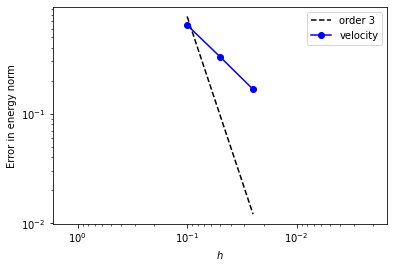

In [10]:
wcoeffs = np.eye(10)

x = [[], [], [], []]
for _ in range(3):
    x[0].append(np.zeros((0, 2)))
x[1].append(np.array([[1 - i, i] for i in [0.25, 0.5, 0.75]]))
x[1].append(np.array([[0.0, i] for i in [0.25, 0.5, 0.75]]))
x[1].append(np.array([[i, 0.0] for i in [0.25, 0.5, 0.75]]))
x[2].append(np.array([[1 / 3, 1 / 3]]))

M = [[], [], [], []]
for _ in range(3):
    M[0].append(np.zeros((0, 1, 0, 1)))
for _ in range(3):
    M[1].append(np.array([[[[1.], [0.], [0.]]], [[[0.], [1.], [0.]]], [[[0.], [0.], [1.]]]]))
M[2].append(np.array([[[[1.]]]]))

crouzeix_falk = basix.ufl_wrapper.BasixElement(basix.create_custom_element(
    basix.CellType.triangle, [], wcoeffs, x, M, 0, basix.MapType.identity, False, 3, 3))
element = ufl.MixedElement(
    ufl.VectorElement(crouzeix_falk),
    ufl.FiniteElement("DG", "triangle", 2))

error_plot(element, 3, 3)

## References

Crouzeix, Michel and Falk, Richard S. Nonconforming finite elements for the Stokes problem, *Mathematics of Computation* 52, 437–456, 1989. [DOI: [10.2307/2008475](https://doi.org/10.2307/2008475)]

Crouzeix, Michel and Raviart, Pierre-Arnaud. Conforming and nonconforming finite element methods for solving the stationary Stokes equations, *Revue Française d'Automatique, Informatique et Recherche Opérationnelle* 3, 33–75, 1973. [DOI: [10.1051/m2an/197307R300331](https://doi.org/10.1051/m2an/197307R300331)]

Fortin, Michel. Calcul numérique des écoulements des fluides de Bingham et des fluides newtoniens incompressibles par la méthode des éléments finis (PhD thesis), Univ. Paris, 1972. 